# Le modèle logistique pour le calage

## Introduction

The logistic growth model is the differential equation:
$$
y’(t) = ay(t) - by(t)^2
$$
for any $t\in[t_0, t_{final}]$, with the initial condition:
$$
y(t_0) = y_0
$$
where

- $a > 0$ and $b > 0$ are two real parameters, 
- $y(t)$ is the size of the population at time $t$, 
- $t_0$ is the initial time,
- $y_0$ is the initial population at time $t=t_0$, 
- $t_{final}$ is the final time.

The $a$ parameter sets the growth rate of the population. The $b$ parameter acts as a competition parameter which limits the size of the population by increasing the competition between its members. 

In [1], the author uses this model to simulate the growth of the U.S. population. To do this, the author uses the U.S. census data from 1790 to 1910. For this time interval, R. Pearl and L. Reed [2] computed the following values of the parameters:
$$
a = 0.03134, \qquad 
b = 1.5887 \times 10^{-10}.
$$

Our goal is to use the logistic growth model in order to simulate the solution for a larger time interval, from 1790 to 2000:
$$
t_0 = 1790, \qquad 
t_{final} = 2000.
$$
Then we can compare the predictions of this model with the real evolution of the U.S. population.

We can prove that, if $y_0 > 0$, then the limit population is:
$$
y_{limit} =\frac{a}{b}.
$$
In 1790, the U.S. population was 3.9 Millions inhabitants:
$$
y_0 = 3.9 \times 10^6.
$$
We can prove that the exact solution of the ordinary differential equation is:
$$
y(t)=\frac{ay_0}{by_0+(a-by_0 ) \exp(-a(t-t_0)) }
$$
for any $t\in[t_0, t_{final}]$.

We want to see the solution of the ordinary differential equation when uncertainties are taken into account in the parameters:

- the initial U.S. population $y_0$,
- the parameters $a$ and $b$.

Indeed, Pearl and Reed [2] estimated the parameters $a$ and $b$ using the U.S. census data from 1790 to 1910 while we have the data up to 2000. Moreover, the method used by Pearl and Reed to estimate the parameters could be improved; they only used 3 dates to estimate the parameters instead of using least squares, for example. Finally, Pearl and Reed did not provide confidence intervals for the parameters $a$ and $b$. 

## Normalizing the data

The order of magnitude of $a$ and $b$ are very different. In order to mitigate this, we consider the parameter $c$ as the logarithm of $b$:
$$
c = \log(b).
$$
This leads to the value:
$$
c = \log(1.5887 \times 10^{-10}) = -22.58.
$$

The order of magnitude of the population is $10^6$. This is why we consider the normalized population in millions:
$$
z(t) = \frac{y(t)}{10^6}
$$
for any $t\in[t_0, t_{final}]$.

## Uncertainties

We consider that the parameters $y_0$, $a$, $b$ are independent random variables with the following gaussian distributions.

|Variable|  Distribution|
| ------------- |-------------|
| $Z_0$ | gaussian, mean $z_0$, coefficient of variation 10% |
| $A$ | gaussian, mean $a$, coefficient of variation 30% |
| $C$ | gaussian, mean $c$, coefficient of variation 30% |

These parameters have been set without any particular probabilistic method. An improvement would be to use calibration methods to get a better quantification of these distributions. 
 

## Notes

This example is based on [1], chapter "First order differential equations", page 28. 
The data used in [1] are from [3]. 
The logistic growth model was first suggested by Pierre François Verhulst near 1840. 
The data are from [1] for the time interval from 1790 to 1950, then from [2] for the time interval from 1960 to 2000.

## References

[1] Martin Braun. Differential equations and their applications, Fourth Edition. Texts in applied
mathematics. Springer, 1993.

[2] Cleve Moler. Numerical Computing with Matlab. Society for Industrial Applied Mathematics,
2004.

[3] Raymond Pearl and Lowell Reed. On the rate of growth of the population of the united states
since 1790 and its mathematical representation. Proceedings of the National Academy of Sciences,
1920.


## Analysis of the data

In [14]:
import openturns as ot
import numpy as np

The data in the file is based on 22 dates from 1790 to 2000.

In [23]:
observedSample = ot.Sample_ImportFromCSVFile("calibration_logistic_observations.csv")
nbobs = observedSample.getSize()
nbobs

22

In [29]:
timeObservations = observedSample[:,0]
timeObservations[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Date (Annees)] data=[[1790],[1800],[1810],[1820],[1830]]

In [31]:
populationObservations = observedSample[:,1]
populationObservations[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Population (Millions)] data=[[3.9],[5.3],[7.2],[9.6],[13]]

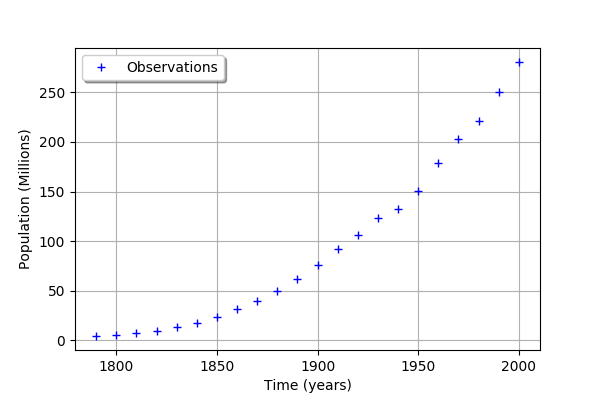

In [32]:
graph = ot.Graph('', 'Time (years)', 'Population (Millions)', True, 'topleft')
cloud = ot.Cloud(timeObservations, populationObservations)
cloud.setLegend("Observations")
graph.add(cloud)
graph

We consider the times and populations as dimension 22 vectors. The `logisticModel` function takes a dimension 24 vector as input and returns a dimension 22 vector. The first 22 components of the input vector contains the dates and the remaining 2 components are $a$ and $b$. 

In [33]:
def logisticModel(X):
    nbdates = 22
    t = [X[i] for i in range(nbdates)]
    a = X[22]
    c = X[23]
    t0 = 1790.
    y0 = 3.9e6
    b = np.exp(c)
    y = ot.Point(nbdates)
    for i in range(nbdates):
        y[i] = a*y0/(b*y0+(a-b*y0)*np.exp(-a*(t[i]-t0)))
    z = y/1.e6 # Convert into millions
    return z

In [34]:
logisticModelPy = ot.PythonFunction(24,22,logisticModel)

The reference values of the parameters. 

Because $b$ is so small with respect to $a$, we use the logarithm. 

In [35]:
np.log(1.5587e-10)

-22.581998789427587

In [36]:
a=0.03134
c=-22.58
thetaPrior = [a,c]

In [37]:
logisticParametric = ot.ParametricFunction(logisticModelPy,[22,23],thetaPrior)

Check that we can evaluate the parametric function.

In [38]:
populationPredicted = logisticParametric(timeObservations.asPoint())
populationPredicted

class=Point name=Unnamed dimension=22 values=[3.9,5.29757,7.17769,9.69198,13.0277,17.4068,23.0769,30.2887,39.2561,50.0977,62.7691,77.0063,92.311,108.001,123.322,137.59,150.3,161.184,170.193,177.442,183.144,187.55]

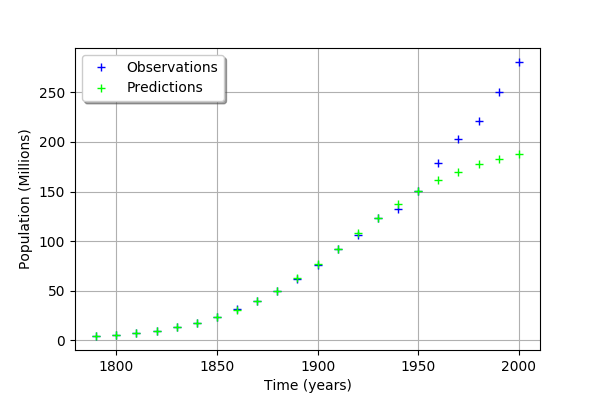

In [39]:
graph = ot.Graph('', 'Time (years)', 'Population (Millions)', True, 'topleft')
# Observations
cloud = ot.Cloud(timeObservations, populationObservations)
cloud.setLegend("Observations")
cloud.setColor("blue")
graph.add(cloud)
# Predictions
cloud = ot.Cloud(timeObservations.asPoint(), populationPredicted)
cloud.setLegend("Predictions")
cloud.setColor("green")
graph.add(cloud)
graph

We see that the fit is not good: the observations continue to grow after 1950, while the growth of the prediction seem to fade.